# Data Analysis

In this notebook, I analyse the distributions of data in the project. Knowing the distributions of the inputs is important both when finding a classifier and when finding good features.

In [2]:
import astropy.convolution
import h5py
import matplotlib.pyplot as plot
import numpy

CROWDASTRO_H5_PATH = '../crowdastro.h5'
TRAINING_H5_PATH = '../training.h5'
WEIGHTS_10_PATH = '../crowdastro-data/weights_10epochs.h5'
WEIGHTS_100_PATH = '../crowdastro-data/my_cnn_weights.h5'
MODEL_PATH = '../crowdastro-data/cnn_model.json'

%matplotlib inline

## Stellarity index

The SWIRE data contain a measure of how likely objects are to be stars. We don't want to classify stars (just galaxies) so we need to remove objects above a certain stellarity value. It's not obvious what stellarity value should be our cutoff, though, so we should have a look at the distribution to see if we can gain some insights into the problem.

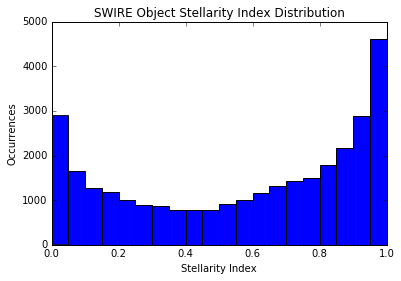

In [2]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    stellarities = f_h5['/swire/cdfs/catalogue'][:, 7]
    plot.title('SWIRE Object Stellarity Index Distribution')
    plot.xlabel('Stellarity Index')
    plot.ylabel('Occurrences')
    plot.hist(stellarities, bins=20)

We can get a different feel for the data with a line plot.

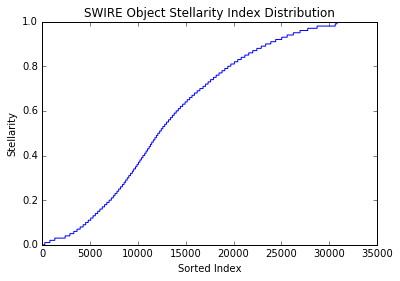

In [3]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    stellarities = f_h5['/swire/cdfs/catalogue'][:, 7]
    plot.title('SWIRE Object Stellarity Index Distribution')
    plot.xlabel('Sorted Index')
    plot.ylabel('Stellarity')
    plot.plot(sorted(stellarities))

## Flux distributions

We want to use the fluxes as inputs to the classifier, so it's useful to know their distribution, too. These have a really unbalanced distribution (probably because of stars) so I'll use a line plot instead of a histogram.

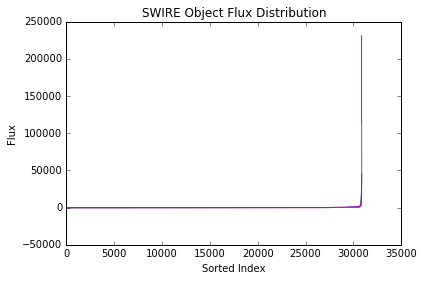

In [4]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    fluxes = f_h5['/swire/cdfs/catalogue'][:, 2:7]
    plot.title('SWIRE Object Flux Distribution')
    plot.xlabel('Sorted Index')
    plot.ylabel('Flux')
    for band in range(5):
        plot.plot(sorted(fluxes[:, band]))

It looks like we have two levels of flux, here &mdash; ~220000 dim objects, and some number of really bright objects. Let's split this up a bit by filtering on high flux.

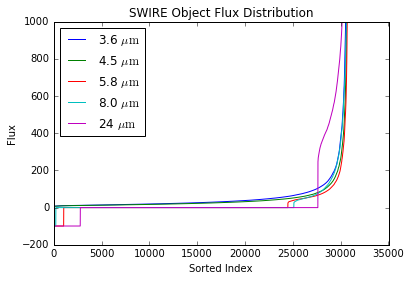

In [5]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    fluxes = f_h5['/swire/cdfs/catalogue'][:, 2:7]
    plot.title('SWIRE Object Flux Distribution')
    plot.xlabel('Sorted Index')
    plot.ylabel('Flux')
    for band in range(5):
        plot.plot(sorted(fluxes[:, band][fluxes[:, band] < 1000]))
    plot.legend(['3.6 $\mu\mathrm{m}$', '4.5 $\mu\mathrm{m}$', '5.8 $\mu\mathrm{m}$',
                 '8.0 $\mu\mathrm{m}$', '24 $\mu\mathrm{m}$'], loc='upper left')

That's an unusual looking distribution. We can probably make a histogram now.

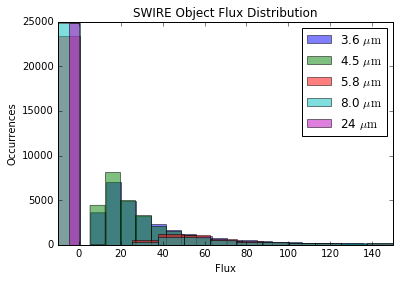

In [6]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    fluxes = f_h5['/swire/cdfs/catalogue'][:, 2:7]
    plot.title('SWIRE Object Flux Distribution')
    plot.xlabel('Flux')
    plot.ylabel('Occurrences')
    for band in range(5):
        plot.hist(fluxes[:, band][fluxes[:, band] < 150], alpha=0.5, bins=20)
    plot.xlim((-10, 150))
    plot.legend(['3.6 $\mu\mathrm{m}$', '4.5 $\mu\mathrm{m}$', '5.8 $\mu\mathrm{m}$',
                 '8.0 $\mu\mathrm{m}$', '24 $\mu\mathrm{m}$'], loc='upper right')

There are very few fluxes $>150$ so I've cut the plot off there. What about the high end?

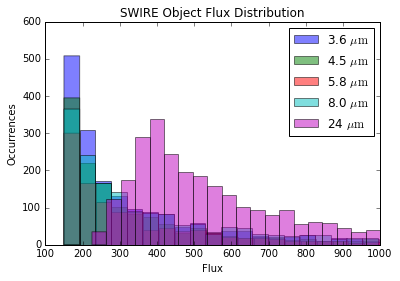

In [7]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    fluxes = f_h5['/swire/cdfs/catalogue'][:, 2:7]
    plot.title('SWIRE Object Flux Distribution')
    plot.xlabel('Flux')
    plot.ylabel('Occurrences')
    for band in range(5):
        plot.hist(fluxes[:, band][numpy.logical_and(1000 > fluxes[:, band], fluxes[:, band] > 150)], alpha=0.5, bins=20)
    plot.legend(['3.6 $\mu\mathrm{m}$', '4.5 $\mu\mathrm{m}$', '5.8 $\mu\mathrm{m}$',
                 '8.0 $\mu\mathrm{m}$', '24 $\mu\mathrm{m}$'], loc='upper right')

And the *higher* end?

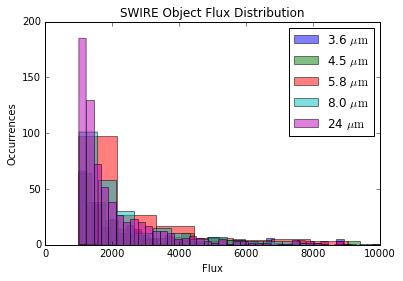

In [8]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    fluxes = f_h5['/swire/cdfs/catalogue'][:, 2:7]
    plot.title('SWIRE Object Flux Distribution')
    plot.xlabel('Flux')
    plot.ylabel('Occurrences')
    for band in range(5):
        plot.hist(fluxes[:, band][fluxes[:, band] > 1000], alpha=0.5, bins=200)
    plot.xlim((0, 10000))
    plot.legend(['3.6 $\mu\mathrm{m}$', '4.5 $\mu\mathrm{m}$', '5.8 $\mu\mathrm{m}$',
                 '8.0 $\mu\mathrm{m}$', '24 $\mu\mathrm{m}$'], loc='upper right')

There's a handful of outliers at really, really high fluxes. I've cut those off. I think that we could safely cut off the flux at $1000$ or at $150$. How many points would I lose?

In [9]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    fluxes = f_h5['/swire/cdfs/catalogue'][:, 2]  # Just the 3.6 μm ones for now.
    print('Total objects:', len(fluxes))
    print('Total objects with flux <1000:', (fluxes < 1000).sum())
    print('Total objects with flux <150:', (fluxes < 150).sum())

Total objects: 30853
Total objects with flux <1000: 30512
Total objects with flux <150: 28766


## Stellarity and flux correlation

Maybe the bright SWIRE objects are stars? If so, how many of them are likely to be stars? How is the flux and the stellarity correlated?

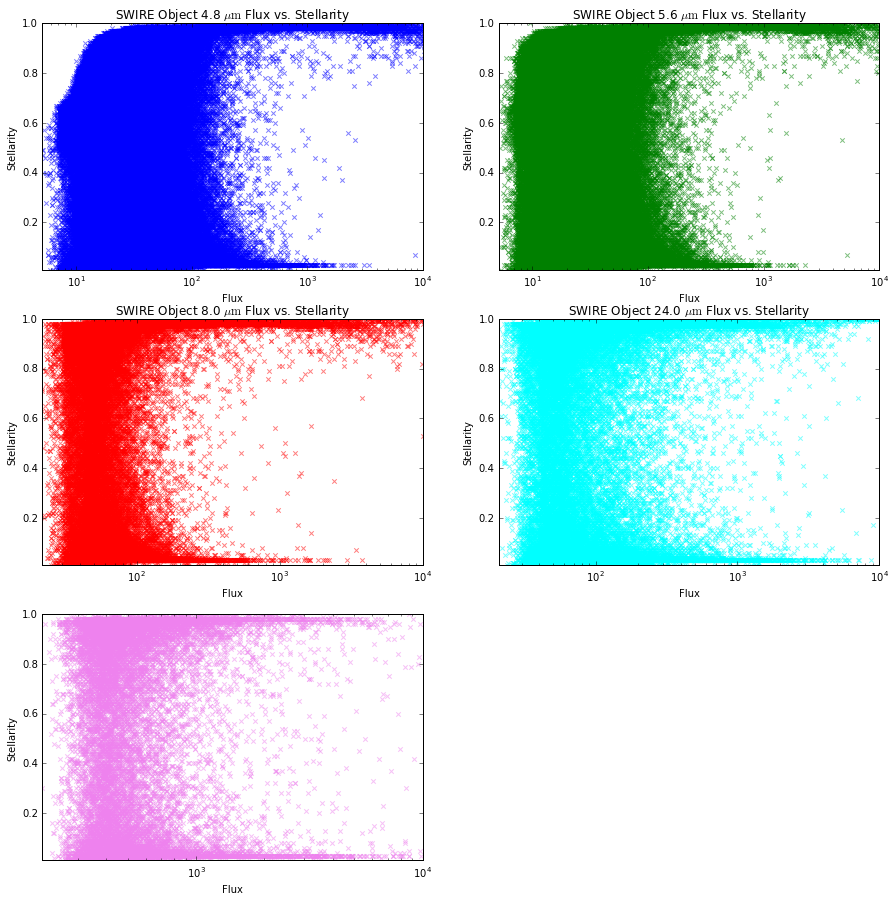

In [146]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    fluxes = f_h5['/swire/cdfs/catalogue'][:, 2:7]
    stellarities = f_h5['/swire/cdfs/catalogue'][:, 7]
    colours = ['blue', 'green', 'red', 'cyan', 'violet']
    bands = [3.6, 4.8, 5.6, 8.0, 24.0]
    plot.figure(figsize=(15, 15))
    for band in range(5):
        plot.title('SWIRE Object {} $\mu\mathrm{{m}}$ Flux vs. Stellarity'.format(bands[band]))
        plot.subplot(3, 2, band + 1)
        plot.xlabel('Flux')
        plot.ylabel('Stellarity')
        plot.xscale('log')
        plot.ylim((1e-2, 1))
        plot.xlim((min(fluxes[:, band][numpy.logical_and(fluxes[:, band] > 0, stellarities > 0)]), 1e4))
        plot.scatter(fluxes[:, band][numpy.logical_and(fluxes[:, band] > 0, stellarities > 0)],
                     stellarities[numpy.logical_and(fluxes[:, band] > 0, stellarities > 0)],
                     marker='x', color=colours[band], alpha=0.5)

Let's also check statistically.

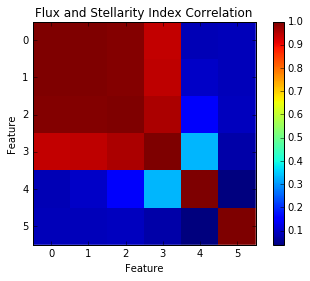

In [144]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    datapoints = f_h5['/swire/cdfs/catalogue'][:, 2:8][numpy.random.randint(200000, size=1000)].T
    cor = numpy.corrcoef(datapoints)
    plot.imshow(cor, interpolation='None')
    plot.colorbar()
    plot.xlabel('Feature')
    plot.ylabel('Feature')
    plot.title('Flux and Stellarity Index Correlation')

So the stellarity and flux are not strongly correlated.

## The CDFS field

What does the distribution of objects in SWIRE&ndash;CDFS look like? What about the distribution of objects in ATLAS&ndash;CDFS?

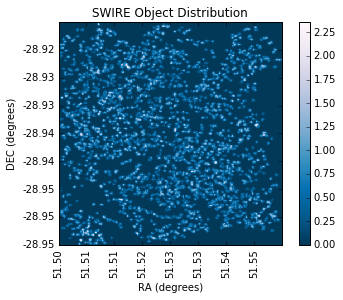

In [19]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    swire = f_h5['/swire/cdfs/catalogue']
    ras = swire[:, 0]
    decs = swire[:, 1]
    ras_idx = numpy.linspace(numpy.min(ras), numpy.max(ras), num=400)
    dec_idx = numpy.linspace(numpy.min(decs), numpy.max(decs), num=400)
    heatmap, _, _ = numpy.histogram2d(ras, decs, bins=[ras_idx, dec_idx])
    plot.pcolor(
            astropy.convolution.convolve(heatmap, astropy.convolution.Gaussian2DKernel(stddev=1)),
            cmap='PuBu_r')
    plot.axis('scaled')
    plot.colorbar()
    plot.title('SWIRE Object Distribution')
    plot.xlabel('RA (degrees)')
    plot.ylabel('DEC (degrees)')
    plot.xticks(range(0, 400, 50), ['{:.02f}'.format(i) for i in ras_idx], rotation=90)
    plot.yticks(range(0, 400, 50), ['{:.02f}'.format(i) for i in dec_idx])

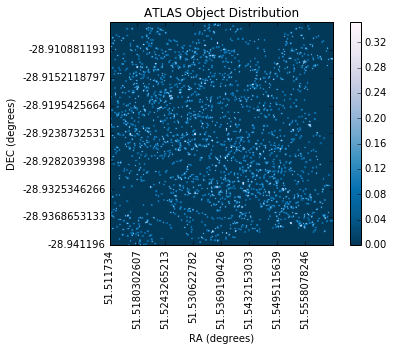

In [158]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    atlas = f_h5['/atlas/cdfs/positions']
    ras = atlas[:, 0]
    decs = atlas[:, 1]
    ras_idx = numpy.linspace(numpy.min(ras), numpy.max(ras), num=400)
    dec_idx = numpy.linspace(numpy.min(decs), numpy.max(decs), num=400)
    heatmap, _, _ = numpy.histogram2d(ras, decs, bins=[ras_idx, dec_idx])
    plot.pcolor(
            astropy.convolution.convolve(heatmap, astropy.convolution.Gaussian2DKernel(stddev=1)),
            cmap='PuBu_r')
    plot.axis('scaled')
    plot.colorbar()
    plot.title('ATLAS Object Distribution')
    plot.xlabel('RA (degrees)')
    plot.ylabel('DEC (degrees)')
    plot.xticks(range(0, 400, 50), ras_idx, rotation=90)
    plot.yticks(range(0, 400, 50), dec_idx)

## CNN feature variance

We have a few black-box CNNs for processing radio images, but we have no idea if these features are good. Do they tend to correlate? Are some of them always zero? I'll have a look at both my 100-epoch trial and Cheng's 10-epoch trial (with way, way more training data).

In [177]:
import keras.layers.convolutional
import keras.layers.core
import keras.models

with open(MODEL_PATH) as f:
    model = keras.models.model_from_json(f.read())
model.load_weights(WEIGHTS_10_PATH)

# Make a new model that just re-uses these filters.
big_model = keras.models.Sequential()

n_filters = 32
conv_size = 10
pool_size = 5
hidden_layer_size = 64

big_model.add(keras.layers.convolutional.Convolution2D(n_filters, conv_size, conv_size,
                                                       border_mode='valid',
                                                       input_shape=(1, 201, 201),
                                                       weights=model.layers[0].get_weights()))
big_model.add(keras.layers.core.Activation('relu'))
big_model.add(keras.layers.convolutional.MaxPooling2D(pool_size=(pool_size, pool_size)))
big_model.add(keras.layers.convolutional.Convolution2D(n_filters, conv_size, conv_size,
                                                       border_mode='valid',
                                                       weights=model.layers[3].get_weights()))
big_model.add(keras.layers.core.Activation('relu'))
big_model.compile(loss='binary_crossentropy', optimizer='adadelta')

Let's start by looking at some features from the two sets of weights.

CNN trained with 10 epochs, large data count


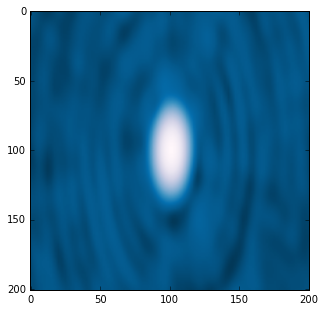

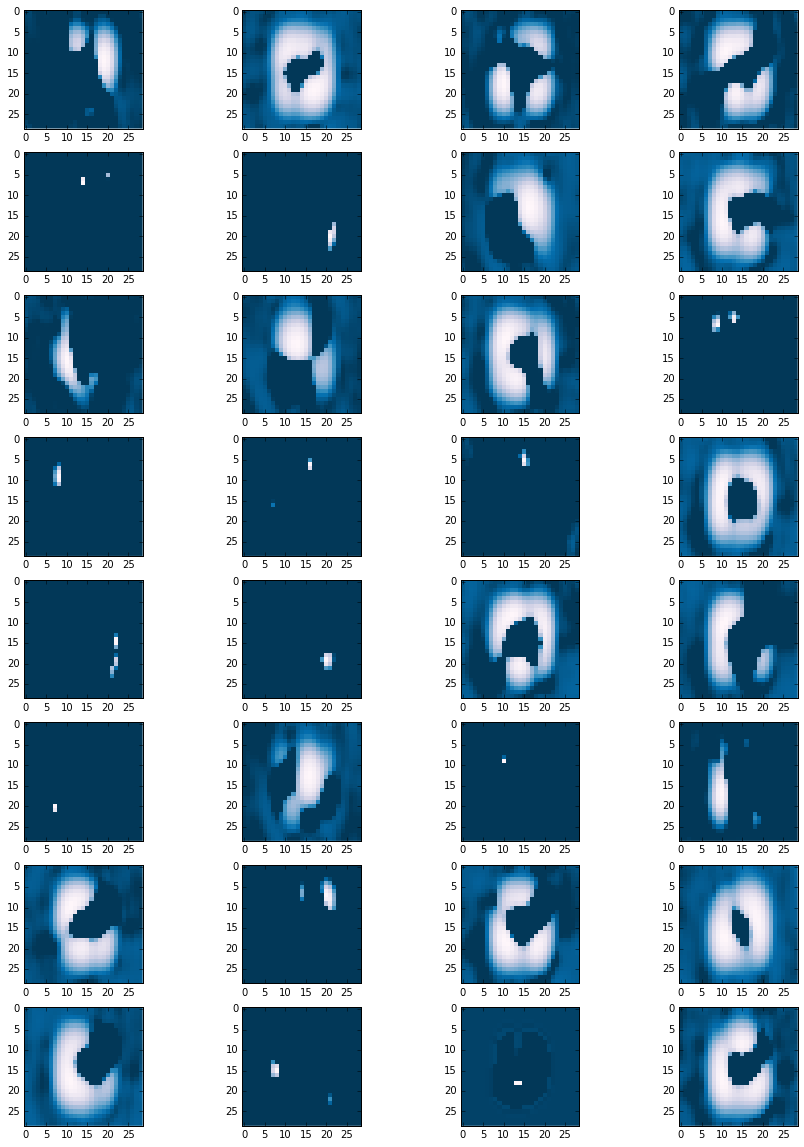

In [222]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    sample_radio = f_h5['/atlas/cdfs/images_2x2'][0]
    sample_output = big_model.predict(sample_radio.reshape(1, 1, 201, 201))
    
    print('CNN trained with 10 epochs, large data count')
    
    plot.figure(figsize=(5, 5))
    plot.imshow(numpy.log(sample_radio + sample_radio.min() + 10), cmap='PuBu_r')
    plot.show()
    
    plot.figure(figsize=(15, 20))
    for i in range(32):
        plot.subplot(8, 4, i + 1)
        plot.imshow(numpy.log(sample_output[0, i] + sample_output[0, i].min() + 10), interpolation='None', cmap='PuBu_r')

In [223]:
with open(MODEL_PATH) as f:
    model = keras.models.model_from_json(f.read())
model.load_weights(WEIGHTS_100_PATH)

# Make a new model that just re-uses these filters.
big_model = keras.models.Sequential()

n_filters = 32
conv_size = 10
pool_size = 5
hidden_layer_size = 64

big_model.add(keras.layers.convolutional.Convolution2D(n_filters, conv_size, conv_size,
                                                       border_mode='valid',
                                                       input_shape=(1, 201, 201),
                                                       weights=model.layers[0].get_weights()))
big_model.add(keras.layers.core.Activation('relu'))
big_model.add(keras.layers.convolutional.MaxPooling2D(pool_size=(pool_size, pool_size)))
big_model.add(keras.layers.convolutional.Convolution2D(n_filters, conv_size, conv_size,
                                                       border_mode='valid',
                                                       weights=model.layers[3].get_weights()))
big_model.add(keras.layers.core.Activation('relu'))
big_model.compile(loss='binary_crossentropy', optimizer='adadelta')

CNN trained with 100 epochs, small data count


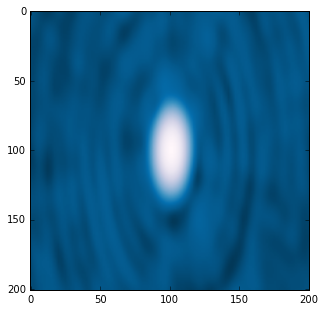

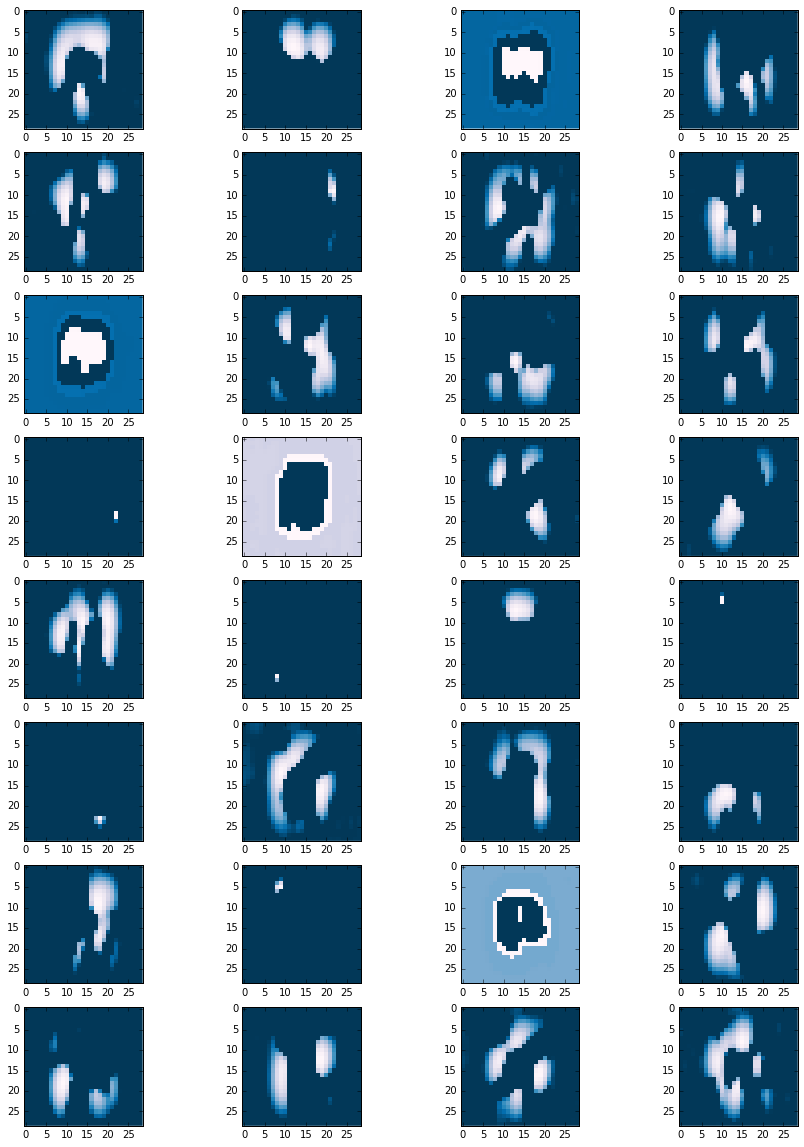

In [225]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    sample_radio = f_h5['/atlas/cdfs/images_2x2'][0]
    sample_output = big_model.predict(sample_radio.reshape(1, 1, 201, 201))
    
    print('CNN trained with 100 epochs, small data count')
    
    plot.figure(figsize=(5, 5))
    plot.imshow(numpy.log(sample_radio + sample_radio.min() + 10), cmap='PuBu_r')
    plot.show()
    
    plot.figure(figsize=(15, 20))
    for i in range(32):
        plot.subplot(8, 4, i + 1)
        plot.imshow(numpy.log(sample_output[0, i] + sample_output[0, i].min() + 100), interpolation='None', cmap='PuBu_r')

The 100 epoch weights seem to give more varied features. Let's also try *random* weights, just for fun.

In [231]:
big_model = keras.models.Sequential()

n_filters = 32
conv_size = 10
pool_size = 5
hidden_layer_size = 64

big_model.add(keras.layers.convolutional.Convolution2D(n_filters, conv_size, conv_size,
                                                       border_mode='valid',
                                                       input_shape=(1, 201, 201),
                                                       weights=[numpy.random.random(size=(32, 1, 10, 10)),
                                                                numpy.random.random(size=(32,))]))
big_model.add(keras.layers.core.Activation('relu'))
big_model.add(keras.layers.convolutional.MaxPooling2D(pool_size=(pool_size, pool_size)))
big_model.add(keras.layers.convolutional.Convolution2D(n_filters, conv_size, conv_size,
                                                       border_mode='valid',
                                                       weights=[numpy.random.random(size=(32, 32, 10, 10)),
                                                                numpy.random.random(size=(32,))]))
big_model.add(keras.layers.core.Activation('relu'))
big_model.compile(loss='binary_crossentropy', optimizer='adadelta')

Random CNN


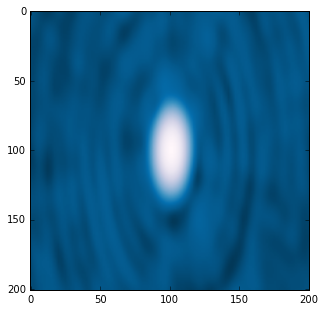

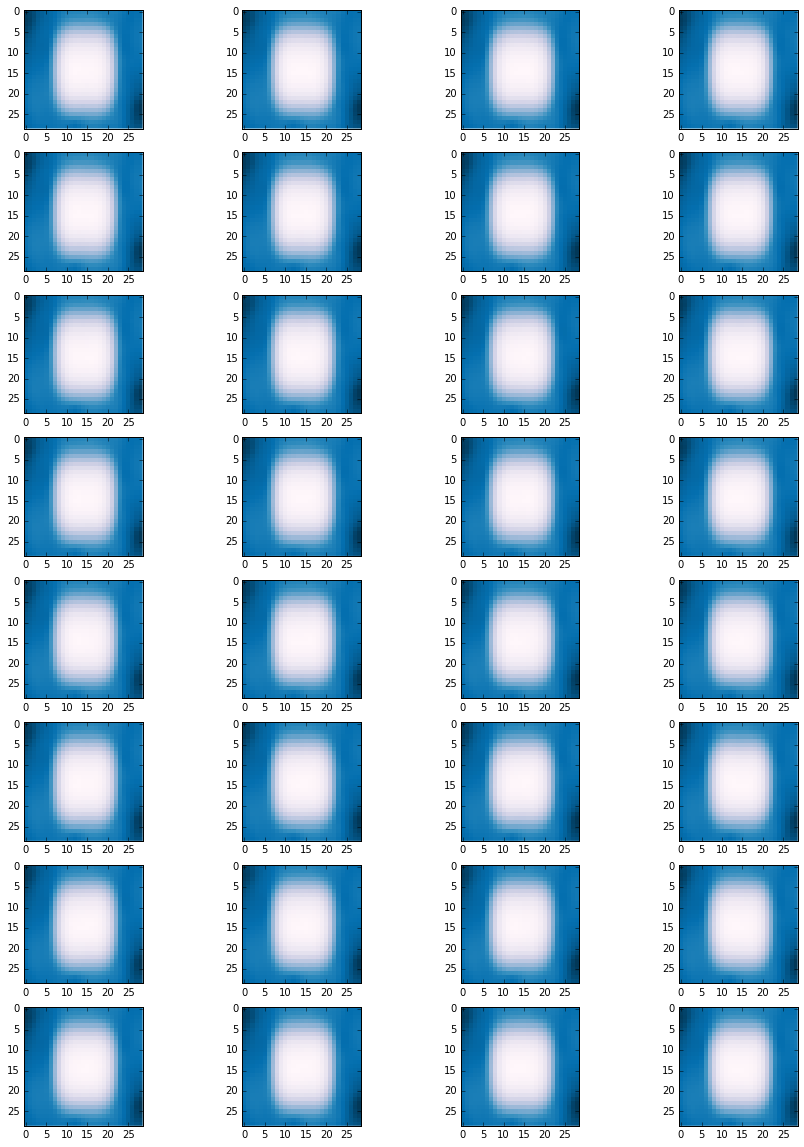

In [232]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    sample_radio = f_h5['/atlas/cdfs/images_2x2'][0]
    sample_output = big_model.predict(sample_radio.reshape(1, 1, 201, 201))
    
    print('Random CNN')
    
    plot.figure(figsize=(5, 5))
    plot.imshow(numpy.log(sample_radio + sample_radio.min() + 10), cmap='PuBu_r')
    plot.show()
    
    plot.figure(figsize=(15, 20))
    for i in range(32):
        plot.subplot(8, 4, i + 1)
        plot.imshow(numpy.log(sample_output[0, i] + sample_output[0, i].min() + 100), interpolation='None', cmap='PuBu_r')

So random weights are terrible (as expected). Interestingly, random CNN weights tend to perform edge detection on sharp images, furthering the idea that "there are no edges in space".

The next question is, are some of the features always zero? What does an average feature vector look like? How much do the feature vectors vary? I'll reload the 10 epoch weights and have a look.

In [251]:
with open(MODEL_PATH) as f:
    model = keras.models.model_from_json(f.read())
model.load_weights(WEIGHTS_10_PATH)

# Make a new model that just re-uses these filters.
big_model = keras.models.Sequential()

n_filters = 32
conv_size = 10
pool_size = 5
hidden_layer_size = 64

big_model.add(keras.layers.convolutional.Convolution2D(n_filters, conv_size, conv_size,
                                                       border_mode='valid',
                                                       input_shape=(1, 201, 201),
                                                       weights=model.layers[0].get_weights()))
big_model.add(keras.layers.core.Activation('relu'))
big_model.add(keras.layers.convolutional.MaxPooling2D(pool_size=(pool_size, pool_size)))
big_model.add(keras.layers.convolutional.Convolution2D(n_filters, conv_size, conv_size,
                                                       border_mode='valid',
                                                       weights=model.layers[3].get_weights()))
big_model.add(keras.layers.core.Activation('relu'))
big_model.compile(loss='binary_crossentropy', optimizer='adadelta')

Average outputs


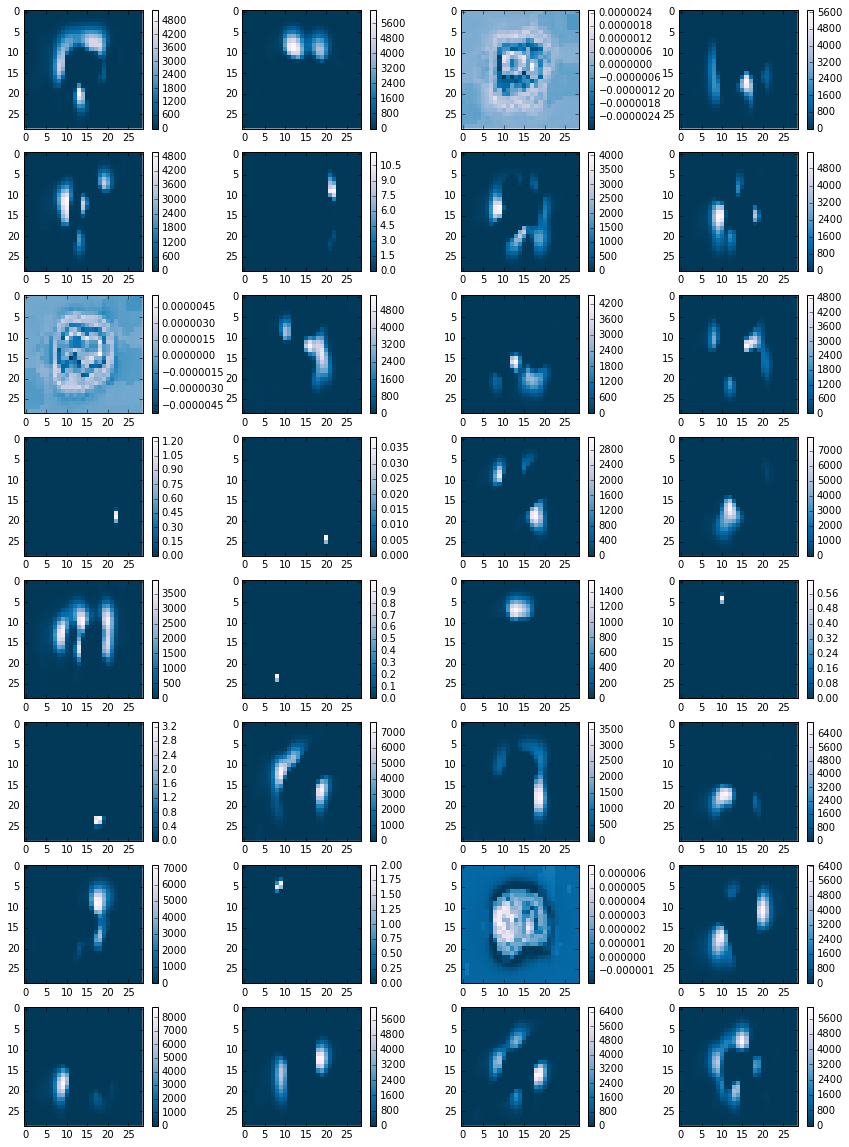

Stdev of average outputs


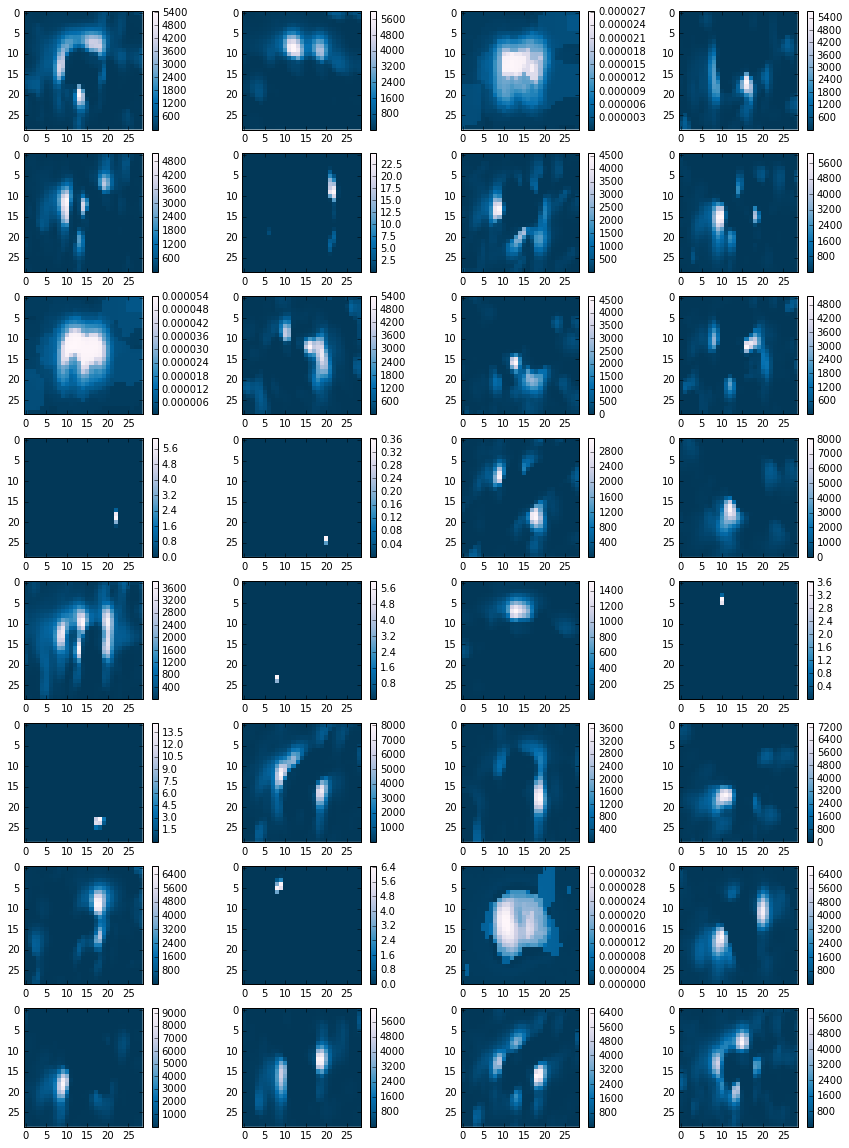

In [250]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    radio = f_h5['/atlas/cdfs/images_2x2'][:100]
    output = big_model.predict(radio.reshape(-1, 1, 201, 201))
    
    print('Average outputs')
    
    plot.figure(figsize=(15, 20))
    for i in range(32):
        plot.subplot(8, 4, i + 1)
        plot.imshow(output.mean(axis=0)[i], interpolation='None', cmap='PuBu_r')
        plot.colorbar()
    plot.show()
    
    print('Stdev of average outputs')
    
    plot.figure(figsize=(15, 20))
    for i in range(32):
        plot.subplot(8, 4, i + 1)
        plot.imshow(output.std(axis=0)[i], interpolation='None', cmap='PuBu_r')
        plot.colorbar()
    plot.show()

## Stellarity of consensus hosts

What are the stellarity indices of hosts chosen by volunteers?

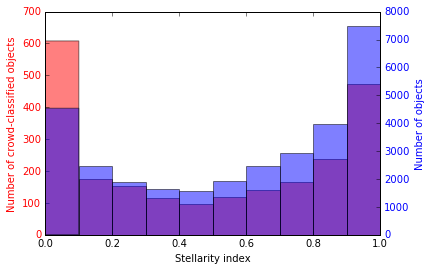

In [6]:
with h5py.File(CROWDASTRO_H5_PATH) as crowdastro_h5:
    with h5py.File(TRAINING_H5_PATH) as training_h5:
        labels = training_h5['labels']
        stellarities = crowdastro_h5['/swire/cdfs/catalogue'][:, 7]
        crowd_stellarities = crowdastro_h5['/swire/cdfs/catalogue'][labels.value == 1, 7]
        
        fig, ax1 = plot.subplots()
        ax1.hist(crowd_stellarities, alpha=0.5, color='red')
        ax1.set_xlabel('Stellarity index')
        ax1.set_ylabel('Number of crowd-classified objects', color='red')
        for t in ax1.get_yticklabels():
            t.set_color('red')

        ax2 = ax1.twinx()
        plot.hist(stellarities, alpha=0.5, color='blue')
        ax2.set_ylabel('Number of objects', color='blue')
        for t in ax2.get_yticklabels():
            t.set_color('blue')

So less-stellar objects are preferred, but not by much.